In [0]:

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import tensorflow as tf
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [7]:
!unzip '/content/drive/My Drive/hackathon/data/images.zip'

Archive:  /content/drive/My Drive/hackathon/data/images.zip
  inflating: images/9326871.1.jpg    
  inflating: images/9326871.10.jpg   
  inflating: images/9326871.11.jpg   
  inflating: images/9326871.12.jpg   
  inflating: images/9326871.13.jpg   
  inflating: images/9326871.14.jpg   
  inflating: images/9326871.15.jpg   
  inflating: images/9326871.16.jpg   
  inflating: images/9326871.17.jpg   
  inflating: images/9326871.18.jpg   
  inflating: images/9326871.19.jpg   
  inflating: images/9326871.2.jpg    
  inflating: images/9326871.20.jpg   
  inflating: images/9326871.3.jpg    
  inflating: images/9326871.4.jpg    
  inflating: images/9326871.5.jpg    
  inflating: images/9326871.6.jpg    
  inflating: images/9326871.7.jpg    
  inflating: images/9326871.8.jpg    
  inflating: images/9326871.9.jpg    
  inflating: images/9332898.1.jpg    
  inflating: images/9332898.10.jpg   
  inflating: images/9332898.11.jpg   
  inflating: images/9332898.12.jpg   
  inflating: images/9332898.

In [8]:
!unzip '/content/drive/My Drive/hackathon/data/images.zip' -d "/content/drive/My Drive/hackathon/data"

Archive:  /content/drive/My Drive/hackathon/data/images.zip
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.1.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.10.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.11.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.12.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.13.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.14.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.15.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.16.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.17.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.18.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.19.jpg  
  inflating: /content/drive/My Drive/hackathon/data/images/9326871.2.jpg  
  inflating: /content/drive/My

In [60]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16


# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/hackathon/data'
EPOCHS = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [55]:
# Image set has 11,682 images.  Can take over an hour for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/hackathon/data/training_data_96_96.npy
Loading previous training pickle...


In [0]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    input=Input(shape=(seed_size,))
    generated_image=model(input)
    return Model(input,generated_image)


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    input_image=Input(shape=image_shape)
    validity=model(input_image)

    return Model(input_image,validity)

In [0]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)


In [58]:
image_shape=(GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
optimizer=Adam(1.5e-4,0.5)
discriminator=build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=["accuracy"])
generator=build_generator(SEED_SIZE,IMAGE_CHANNELS)
random_input=Input(shape=(SEED_SIZE,))
generated_image=generator(random_input)
discriminator.trainable=False
validity=discriminator(generated_image)
combined=Model(random_input,validity)
combined.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.












In [61]:
SAVE_FREQ=100
y_real=np.ones((BATCH_SIZE,1))
y_fake=np.zeros((BATCH_SIZE,1))
fixed_seed =np.random.normal(0,1,(PREVIEW_ROWS*PREVIEW_COLS,SEED_SIZE))
cnt=1
for epoch in range(EPOCHS):
  idx=np.random.randint(0,training_data.shape[0],BATCH_SIZE)
  x_real=training_data[idx]
  seed=np.random.normal(0,1,(BATCH_SIZE,SEED_SIZE))
  x_fake=generator.predict(seed)
  discriminator_metric_real=discriminator.train_on_batch(x_real,y_real)
  discriminator_metric_fake=discriminator.train_on_batch(x_fake,y_fake)
  discriminator_metric=0.5*np.add(discriminator_metric_real,discriminator_metric_fake)
  generator_metric=combined.train_on_batch(seed,y_real)
  if epoch % SAVE_FREQ==0:
    save_images(cnt,fixed_seed)
    cnt+=1
    print(f"Epoch {epoch},Discriminator accuracy:{discriminator_metric[1]},generator accuracy:{generator_metric[1]}")
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))    


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0,Discriminator accuracy:0.75,generator accuracy:0.0
Epoch 100,Discriminator accuracy:0.4375,generator accuracy:0.0625
Epoch 200,Discriminator accuracy:0.71875,generator accuracy:0.03125
Epoch 300,Discriminator accuracy:0.59375,generator accuracy:0.125
Epoch 400,Discriminator accuracy:0.828125,generator accuracy:0.0
Epoch 500,Discriminator accuracy:0.734375,generator accuracy:0.03125
Epoch 600,Discriminator accuracy:0.609375,generator accuracy:0.0625
Epoch 700,Discriminator accuracy:0.65625,generator accuracy:0.125
Epoch 800,Discriminator accuracy:0.765625,generator accuracy:0.03125
Epoch 900,Discriminator accuracy:0.5625,generator accuracy:0.03125
Epoch 1000,Discriminator accuracy:0.765625,generator accuracy:0.0
Epoch 1100,Discriminator accuracy:0.734375,generator accuracy:0.0
Epoch 1200,Discriminator accuracy:0.40625,generator accuracy:0.0
Epoch 1300,Discriminator accuracy:0.875,generator accuracy:0.125
Epoch 1400,Discriminator accuracy:0.65625,generator accuracy:0.03125
Epoch 

In [106]:
seed=np.random.normal(0,1,(BATCH_SIZE,122))
gee=generator.predict(seed)

NameError: ignored

In [107]:
gee.shape

(20, 96, 96, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


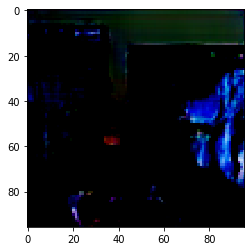

In [108]:
plt.imshow(gee[0])